## Deep Learning Approaches for RF-based detection & classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# import the torch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision.models as models

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm

# import custom functions
from helper_functions import *
from latency_helpers import *
from loading_functions import *

from sklearn import preprocessing

from torchsummary import summary

### Load Features

In [2]:
feat_folder = '../Features/pyplt_spec/'
feat_name = 'SPEC'
seg_len = 20
# datestr = '2022-07-05'
n_per_seg = 1024
interferences = ['WIFI']
output_name = 'drones'
dataset = load_dronedetect_data(feat_folder, feat_name, seg_len, n_per_seg, output_name, interferences)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [04:29<00:00, 11.72s/it]


In [3]:
print('dataset size', len(dataset))
print('shape of each item', dataset.__getitem__(10)[0].shape)

dataset size 10000
shape of each item torch.Size([513, 1327])


In [4]:
## Transfer learning from Resnet50 & Apply Logistic Regression (Swinney paper)

In [5]:
# use pretrained resnet feature and just keep up to the last layer
# resnet50 = models.resnet50(pretrained=True)
# modules=list(resnet50.children())[:-1]
# # resnet50=nn.Sequential(*modules)
# for p in resnet50.parameters():
#     p.requires_grad = False

In [6]:
# test resnet
# input = torch.randn(1,1,30,300)
# inputr = input.repeat(1,3,1,1)
# resnet50(inputr).shape

In [7]:
# resnet_feats = []
# resnet_y = []
# for n in range(len(dataset)):
#     d = dataset.__getitem__(n)
#     inarr = d[0]
#     inputr = inarr.repeat(1,3,1,1)  # repeat to have 3 channels of the same info
#     out = resnet50(inputr)
#     resnet_feats.append(np.array(out))
#     resnet_y.append(np.array(d[1]))

# resnet_feats = np.array(resnet_feats)
# resnet_y = np.array(resnet_y)

# # flatten the middle dimension
# resnet_feats = resnet_feats.reshape(resnet_feats.shape[0], resnet_feats.shape[-1])
# # invert labels back to categorical
# resnet_y_cat = dataset.le.inverse_transform(resnet_y.astype(np.int64))

## Transfer learning VGG16

In [8]:
vgg16 = models.vgg16()
# summary(vgg16, (3,224,224))

modules=list(vgg16.children())[:-1]
vggfeats=nn.Sequential(*modules)

for p in vggfeats.parameters():
    p.requires_grad = False

In [9]:
# test one input
d = dataset.__getitem__(0)
inarr = d[0]
inputr = inarr.repeat(1,3,1,1)
# inputr = inputr.to(device)
out = vggfeats(inputr)

# reshape the output
out.flatten()

tensor([5.0490e-09, 9.0351e-11, 5.0584e-11,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])

In [19]:
inarr.shape

torch.Size([513, 1327])

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vggfeats = vggfeats.to(device) #set model to device

TEST_vgg_feats = []
TEST_vgg_y = []
for n in tqdm(range(len(dataset))):
    d = dataset.__getitem__(n)
    inarr = d[0]
    inputr = inarr.repeat(1,3,1,1)  # repeat to have 3 channels of the same info
    inputr = inputr.to(device)
    out = vggfeats(inputr)
    
    TEST_vgg_feats.append(out.cpu().numpy().flatten())
    TEST_vgg_y.append(np.array(d[1]))

vgg_feats = np.array(TEST_vgg_feats)
vgg_y = np.array(TEST_vgg_y)

# flatten the middle dimension
vgg_feats = vgg_feats.reshape(vgg_feats.shape[0], vgg_feats.shape[-1])
# invert labels back to categorical
vgg_y_cat = dataset.le.inverse_transform(vgg_y.astype(np.int64))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:01<00:00, 33.17it/s]


In [15]:
# Save VGG features
vgg_save = {'feats': vgg_feats, 'y_cat':vgg_y_cat, 'y':vgg_y}
file_name = 'VggFeats_'+str(seg_len)+'_'+str(n_per_seg)+'correct_psd'
np.save(file_name, vgg_save)

In [13]:
feats_lr = vgg_feats # which features to use for logit reg
y_cat = vgg_y_cat
print(feats_lr.shape)

(10000, 25088)


In [7]:
d[0].shape

torch.Size([1024, 1171])

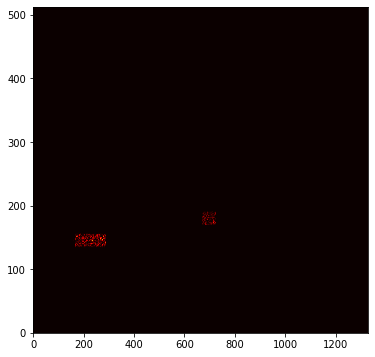

In [11]:
# visualize the spectrograms
import matplotlib.cm as cm

spec = d[0]

fig = plt.figure(figsize=(6,6))
plt.pcolormesh(spec, cmap='hot')
plt.show()
# ax = fig.add_subplot(111, projection='3d')
# n_f, n_t = spec.shape
# t = np.linspace(0,n_t,n_t)
# f = np.linspace(0,n_f,n_f)
# t_2d, f_2d = np.meshgrid(t,f)
# ax.plot_surface(t_2d, f_2d, spec)

# ax.plot_surface(t_2d, f_2d, feats_lr, cmap=cm.jet)
# ax.set_zlim(-0,2)

In [11]:
# split data into K-fold
k_fold = 5
cv = KFold(n_splits=k_fold, random_state=1, shuffle=True)

# model parameters
Cs=list(map(lambda x:pow(2,x),range(-2,10,5)))

best_params_ls = []
acc_ls = []
f1_ls = []
runt_ls = []

parameters = {'C':Cs}

for train_ix, test_ix in tqdm(cv.split(feats_lr)):
    
    # find the optimal hypber parameters
    lr = LogisticRegression()
    clf = GridSearchCV(lr, parameters, n_jobs=1)
    clf.fit(feats_lr[train_ix], y_cat[train_ix])
    
    print(clf.best_params_)
    best_params_ls.append(clf.best_params_)
    
    # predict on the test data
    y_pred, runtimes = atomic_benchmark_estimator(clf, feats_lr[test_ix], output_type= '<U3', 
                                                  verbose=False)
    runt_ls.append(np.mean(runtimes))
    
    acc = accuracy_score(y_cat[test_ix], y_pred)
    f1 = f1_score(y_cat[test_ix], y_pred, average='weighted')
    print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
    acc_ls.append(acc)
    f1_ls.append(f1)
    
out_msg = feat_name+': ResNet+LR average test acc: {:.2}, F1: {:.2}, Run-time: {:.2}ms'.format(np.mean(acc_ls), np.mean(f1_ls), np.mean(runt_ls)*1e3)
print(out_msg)

0it [00:00, ?it/s]

{'C': 8}


1it [00:36, 36.62s/it]

Accuracy: 0.141,	 F1: 0.0348


1it [00:43, 43.69s/it]


KeyboardInterrupt: 

In [15]:
# ## Apply normalization
# X_norm = feats_lr
# for n in range(len(Xs_arr)):
#     X_norm[n] = feats_lr[n]/max(feats_lr[n])
# X_norm.shape

(10000, 25088)

In [17]:
feats_lr.shape

(10000, 25088)

In [18]:
### FIXED PARAMETER LOGISTIC REGRESSION ###
k_fold = 15
cv = KFold(n_splits=k_fold, random_state=10, shuffle=True)

Xs_arr = feats_lr
y_arr = vgg_y

best_params_ls = []
score_ls = []

for train_ix, test_ix in cv.split(Xs_arr):
    
    # find the optimal hypber parameters
    clf = LogisticRegression(C =1e-5, class_weight = 'balanced',n_jobs=-1)
#     clf = svm.SVC(kernel='rbf', C=512, gamma = 0.5)
    clf.fit(Xs_arr[train_ix], y_arr[train_ix])
    
    # predict on the test data
    y_pred = clf.predict(Xs_arr[test_ix])
    acc = accuracy_score(y_arr[test_ix], y_pred)
    print(acc)
    score_ls.append(acc)
    
print('VGG feats+LR K-fold average test score:', np.mean(score_ls))


0.3523238380809595
0.40929535232383807
0.42278860569715143
0.4032983508245877
0.4302848575712144


KeyboardInterrupt: 

## 3. Apply resnet & a fully connected layer

In [ ]:
# # Define network
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
# model.classifier = nn.Linear(model.classifier[0].in_features, num_classes)
# print(model)

In [105]:
class ResnetFC(nn.Module):
    def __init__(self, num_classes):
        super(ResnetFC,self).__init__()
        self.num_classes = num_classes
        self.resnetfull = models.resnet50(pretrained=True)
        modules=list(self.resnetfull.children())[:-2] # remove the fully connected layer & adaptive averaging
        self.resnetfeats=nn.Sequential(*modules)
        
        for param in self.resnetfeats.parameters():
            self.resnetfeats.requires_grad_(False)
        
        self._fc = nn.Linear(1505280, num_classes)
    def forward(self, x):
#         batch_size ,_,_ =x.shape
        
        # replicate the image to have 3 channels
        x = x.repeat(1,3,1,1)
        print(x.shape)
        x = self.resnetfeats(x)
        x = x.flatten()
        print(x.shape)
        x = self._fc(x)
        
        return x

In [106]:
fctest = ResnetFC(7)

In [107]:
test_input = dataset.__getitem__(10)[0]
print(test_input.shape)

torch.Size([129, 4687])


In [110]:
# Test an input
test_input = dataset.__getitem__(10)[0]
# test_input = torch.rand(1, 129, 4687)


test_input = test_input.unsqueeze(axis=0)
print(test_input.shape)
fctest.forward(test_input)

torch.Size([1, 129, 4687])
torch.Size([1, 3, 129, 4687])
torch.Size([1505280])


tensor([ 0.3626,  0.2002,  0.4983, -0.0624, -0.0184, -0.0807,  0.5689],
       grad_fn=<AddBackward0>)

In [82]:
fctest.resnetfeats.cuda()
FULLRES = models.resnet50(pretrained=True)
FULLRES = FULLRES.cuda()
summary(FULLRES, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [89]:
print(list(FULLRES.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

### Kfold CV

In [14]:
from nn_functions import runkfoldcv

In [ ]:
# Configuration options
k_folds = 2

batch_size = 8 # 128
num_classes = 7
learning_rate = 0.01
num_epochs = 1 # 0
momentum = 0.95
l2reg = 1e-4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
runkfoldcv(fctest, dataset, device, k_folds, batch_size, learning_rate, num_epochs, momentum, l2reg)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1


RuntimeError: CUDA out of memory. Tried to allocate 4.65 GiB (GPU 0; 23.65 GiB total capacity; 11.67 GiB already allocated; 2.77 GiB free; 11.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF